In [ ]:
%matplotlib inline
import polars as pl
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'

pl.Config.set_tbl_cols(60)
pl.Config.set_fmt_str_lengths(5000)

plt.rcParams['figure.figsize'] = (15, 5)

Okay! We're going back to our bike path dataset here. I live in Montreal, and I was curious about whether we're more of a commuter city or a biking-for-fun city -- do people bike more on weekends, or on weekdays?

# 4.1 Adding a 'weekday' column to our dataframe

First, we need to load up the data. We've done this before.

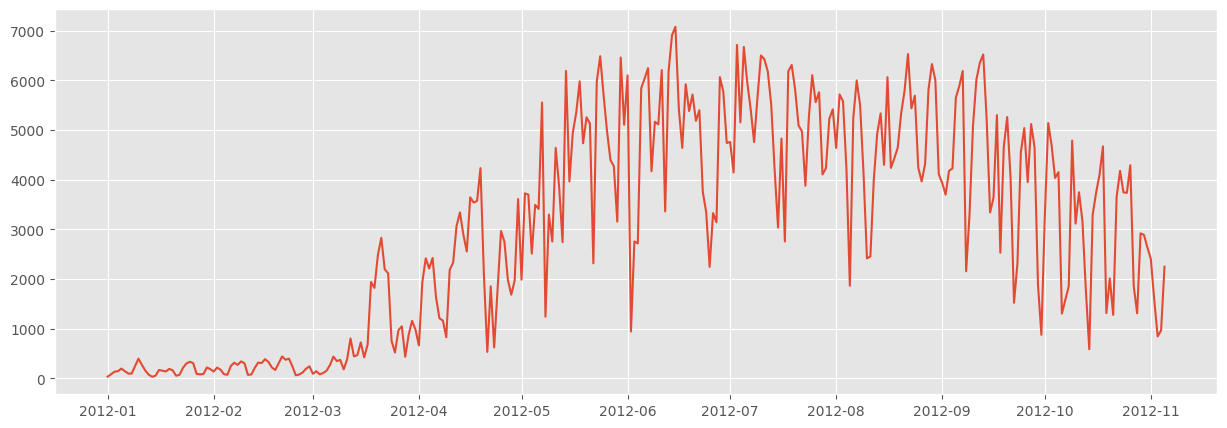

In [ ]:
bikes = pl.read_csv('./data/bikes.csv',separator=';',encoding='latin1').with_columns(pl.col('Date').str.strptime(pl.Date, format='%d/%m/%Y'))
bikes = bikes.with_columns([pl.col('Date').cast(pl.Date)]).sort('Date')

dates = bikes["Date"].to_numpy()
values = bikes['Berri 1'].to_numpy()
plt.plot(dates, values)
plt.show()

Next up, we're just going to look at the Berri bike path. Berri is a street in Montreal, with a pretty important bike path. I use it mostly on my way to the library now, but I used to take it to work sometimes when I worked in Old Montreal. 

So we're going to create a dataframe with just the Berri bikepath in it

In [19]:
#polars does not copy the index, you have to put it explicitily
berri_bikes = bikes.select(['Date','Berri 1']).clone()

In [18]:
berri_bikes

Date,Berri 1
date,i64
2012-01-01,35
2012-01-02,83
2012-01-03,135
2012-01-04,144
2012-01-05,197
…,…
2012-11-01,2405
2012-11-02,1582
2012-11-03,844


Next, we need to add a 'weekday' column. Firstly, we can get the weekday from the index. We haven't talked about indexes yet, but the index is what's on the left on the above dataframe, under 'Date'. It's basically all the days of the year.

In [ ]:
#polars does not have the concept of index like pandas
#berri_bikes.index
berri_bikes['Date']

Date
date
2012-01-01
2012-01-02
2012-01-03
2012-01-04
2012-01-05
…
2012-11-01
2012-11-02
2012-11-03


You can see that actually some of the days are missing -- only 310 days of the year are actually there. Who knows why.

Pandas has a bunch of really great time series functionality, so if we wanted to get the day of the month for each row, we could do it like this:

In [22]:
#no index in polar
#berri_bikes.index.day
berri_bikes.with_columns([
    pl.col('Date').dt.day().alias('Day')
])

Date,Berri 1,Day
date,i64,i8
2012-01-01,35,1
2012-01-02,83,2
2012-01-03,135,3
2012-01-04,144,4
2012-01-05,197,5
…,…,…
2012-11-01,2405,1
2012-11-02,1582,2
2012-11-03,844,3


We actually want the weekday, though:

In [23]:
#berri_bikes.index.weekday
berri_bikes.with_columns([
    pl.col('Date').dt.weekday().alias('Day')
])

Date,Berri 1,Day
date,i64,i8
2012-01-01,35,7
2012-01-02,83,1
2012-01-03,135,2
2012-01-04,144,3
2012-01-05,197,4
…,…,…
2012-11-01,2405,4
2012-11-02,1582,5
2012-11-03,844,6


These are the days of the week, where 0 is Monday. I found out that 0 was Monday by checking on a calendar.

Now that we know how to *get* the weekday, we can add it as a column in our dataframe like this:

In [27]:
berri_bikes = berri_bikes.with_columns([
    pl.col('Date').dt.weekday().alias('weekday')
])
berri_bikes

Date,Berri 1,weekday
date,i64,i8
2012-01-01,35,7
2012-01-02,83,1
2012-01-03,135,2
2012-01-04,144,3
2012-01-05,197,4
…,…,…
2012-11-01,2405,4
2012-11-02,1582,5
2012-11-03,844,6


# 4.2 Adding up the cyclists by weekday

This turns out to be really easy!

Dataframes have a `.groupby()` method that is similar to SQL groupby, if you're familiar with that. I'm not going to explain more about it right now -- if you want to to know more, [the documentation](http://pandas.pydata.org/pandas-docs/stable/groupby.html) is really good.

In this case, `berri_bikes.groupby('weekday').sum()` means "Group the rows by weekday and then add up all the values with the same weekday".

In [33]:
weekday_counts = berri_bikes.group_by('weekday').agg([
    pl.sum('Berri 1').alias('Total_Value')
])
weekday_counts.sort(by='weekday')
#notice polars starts the monday as 1 not 0!

weekday,Total_Value
i8,i64
1,134298
2,135305
3,152972
4,160131
5,141771
6,101578
7,99310


It's hard to remember what 0, 1, 2, 3, 4, 5, 6 mean, so we can fix it up and graph it:

In [47]:
weekday_map = {
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday',
    7: 'Sunday'
}
weekday_counts=weekday_counts.with_columns([
    pl.col('weekday').replace_strict(weekday_map, default=None).alias('Weekday_Name')
])

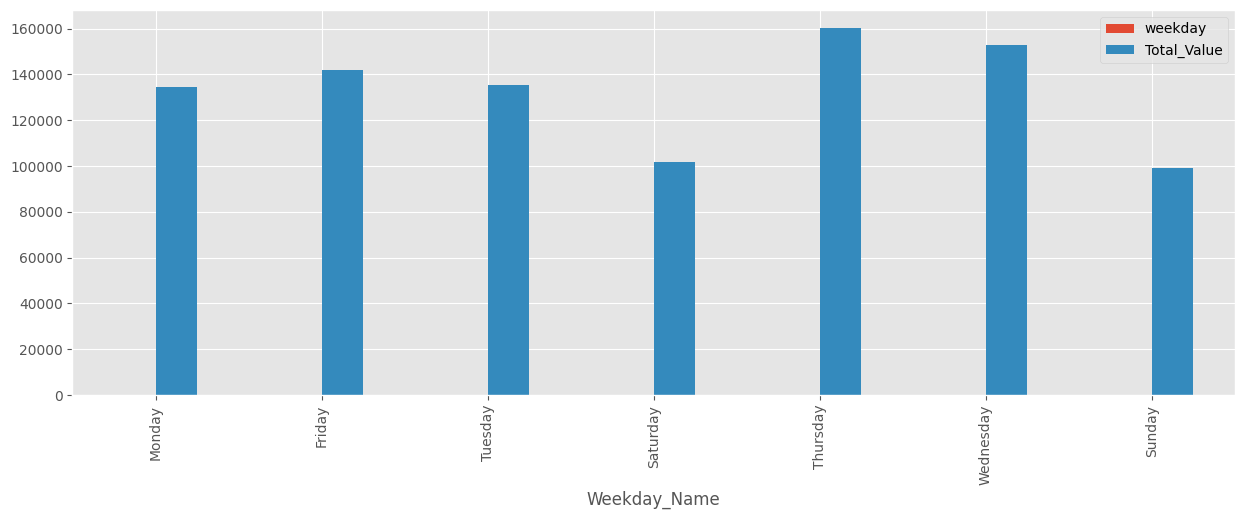

In [48]:
weekday_counts.to_pandas().plot(kind='bar', x='Weekday_Name')
plt.show()

So it looks like Montrealers are commuter cyclists -- they bike much more during the week. Neat!

# 4.3 Putting it together

Let's put all that together, to prove how easy it is. 6 lines of magical pandas!

If you want to play around, try changing `sum` to `max`, `numpy.median`, or any other function you like.

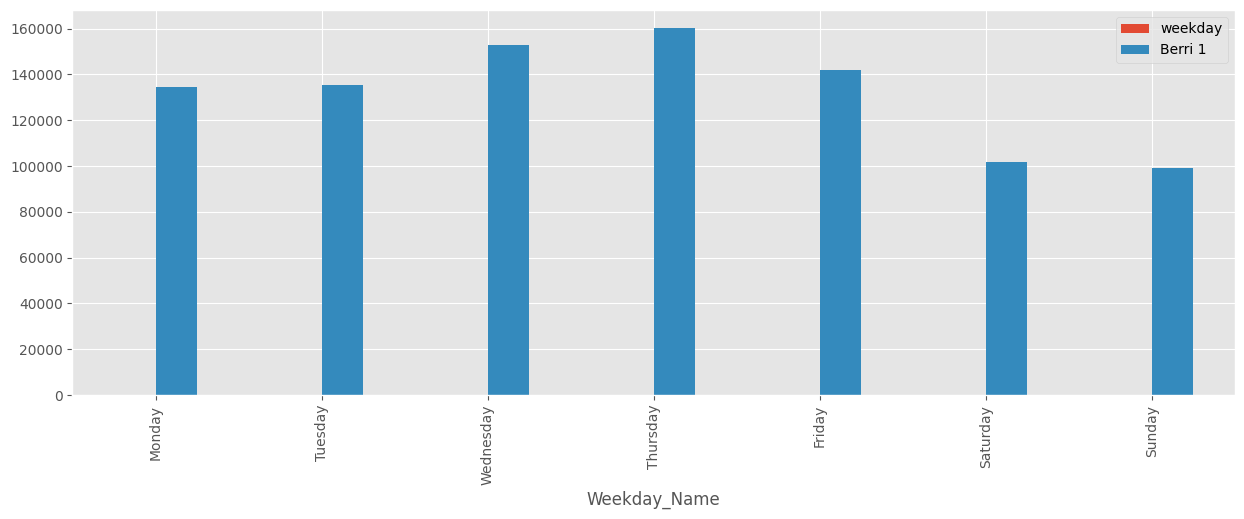

In [55]:
bikes = pl.read_csv('./data/bikes.csv',separator=';',encoding='latin1').with_columns(pl.col('Date').str.strptime(pl.Date, format='%d/%m/%Y'))
bikes = bikes.with_columns([pl.col('Date').cast(pl.Date)])

# Add the weekday column
berri_bikes = berri_bikes.with_columns([
    pl.col('Date').dt.weekday().alias('weekday')
]).sort('weekday')

# Add up the number of cyclists by weekday, and plot!
weekday_counts = berri_bikes.group_by('weekday').agg([
    pl.sum('Berri 1')
])
weekday_map = {
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday',
    7: 'Sunday'
}
weekday_counts=weekday_counts.with_columns([
    pl.col('weekday').replace_strict(weekday_map, default=None).alias('Weekday_Name')
])
weekday_counts.to_pandas().plot(kind='bar', x='Weekday_Name')
plt.show()